In [1]:
# https://zenodo.org/records/4670277
#
#

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import nibabel as nib
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
import os
import matplotlib.gridspec as gridspec
from numpy.linalg import pinv

from Tools.fmri_tools import *
from Tools.model_info_tools import *
from Tools.mathematical_tools import *

from Encoder import*
from scipy.stats import zscore
import torch.optim as optim
from torch.utils.data import DataLoader,random_split



### Load a NN

In [ ]:
# Database path
model_database_path = os.path.join('..','Def_list.json')

# Load all configurations
all_configs = load_configs(model_database_path)
for model_name, config in all_configs.items():
    print(model_name, config)

Example {'model_name': 'Example', 'index': [2, 3, 4], 'min_corr': 0.5, 'max_lag': 30, 'decoder_layers': [10, 45], 'encoder_layers': [15, 10], 'n_components': 3, 'latent_dim': 10, 'embedding_dim': 20, 'tau': 2, 'r': 15, 'epochs': 1000, 'early_stopping': {'patience': 100000, 'delta': -1}, 'beta_method': 'sigmoid', 'beta_value': 0.1, 'kl_annealing_epochs': 500, 'decay_start': 50, 'decay_epoch': 40, 'dataset': 3, 'batch_size': 32, 'optimizer': 'Adam', 'learning_rate': 0.0001, 'scheduler': {'type': 'None', 'params': {'mode': 'min', 'factor': 0.5, 'patience': 10, 'min_lr': 1e-09, 'base_lr': 0.0001, 'max_lr': 0.001, 'step_size_up': 100, 'T_max': 300, 'T_0': 100, 'T_mult': 2, 'eta_min': 1e-08}}}


In [ ]:
# Loading decoder info from Brain Dynamics training
model_name = "Example" 
selected_model_config = all_configs.get(model_name)

if selected_model_config is None:
    raise ValueError(f"Il modello {model_name} non esiste nel database.")

# Dataset preparation parmeters
embedding_dim = selected_model_config['embedding_dim']
tau = selected_model_config['tau']
r = selected_model_config['r']
n_components = selected_model_config['n_components']
index = selected_model_config['index']
min_corr = selected_model_config['min_corr']
max_lag = selected_model_config['max_lag']

# Network Parameters
encoder_layers = selected_model_config['encoder_layers']
decoder_layers = selected_model_config['decoder_layers']
latent_dim = selected_model_config['latent_dim']

# Training Parameters
learning_rate = selected_model_config['learning_rate']
epochs = selected_model_config['epochs']
scheduler = selected_model_config['scheduler']
beta_method = selected_model_config['beta_method']
beta_value = selected_model_config['beta_value']
batch_size = selected_model_config['batch_size']
kl_annealing_epochs = selected_model_config['kl_annealing_epochs']


print('################# EMBEDDING SETTINGS ############################')
print('Embedding dimension:', embedding_dim)
print('Tau:', tau)
print('r:', r)
print('n_components:', n_components)
print('Index:', index)
print('Min correlation:', min_corr)
print('Max lag:', max_lag)
print('################### VAE SETTINGS ###############################')
print('Encoder layers:', encoder_layers)
print('Decoder layers:', decoder_layers)
print('Latent dim:', latent_dim)
print('################# TRAINING SETTINGS ############################')
print('Learning rate:', learning_rate)
print('Epochs:', epochs)
print('Scheduler:', scheduler)
print('Beta method:', beta_method)
print('Beta value:', beta_value)
print('kl_annealing_epochs:', kl_annealing_epochs)
print('Batch size:', batch_size)
print('#################################################################')


################# EMBEDDING SETTINGS ############################
Embedding dimension: 20
Tau: 2
r: 15
n_components: 3
Index: [2, 3, 4]
Min correlation: 0.5
Max lag: 30
################### VAE SETTINGS ###############################
Encoder layers: [15, 10]
Decoder layers: [10, 45]
Latent dim: 10
################# TRAINING SETTINGS ############################
Learning rate: 0.0001
Epochs: 1000
Scheduler: {'type': 'None', 'params': {'mode': 'min', 'factor': 0.5, 'patience': 10, 'min_lr': 1e-09, 'base_lr': 0.0001, 'max_lr': 0.001, 'step_size_up': 100, 'T_max': 300, 'T_0': 100, 'T_mult': 2, 'eta_min': 1e-08}}
Beta method: sigmoid
Beta value: 0.1
kl_annealing_epochs: 500
Batch size: 32
#################################################################


### Training behaviour

c:\Users\Federico\OneDrive\Desktop\fmri-github\Notebooks\Tools\training_tools.py:220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path,map_loc

Decoder and training info loaded from ..\Def Models\Example.pth


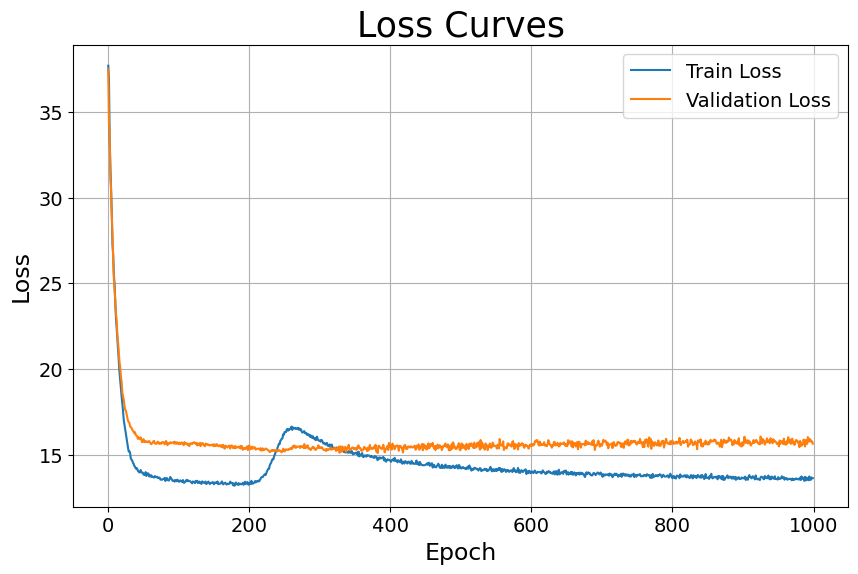

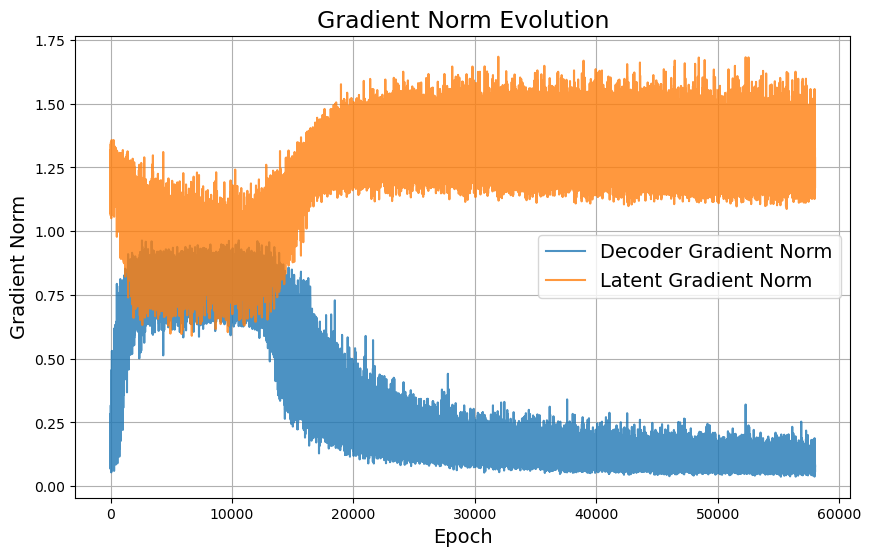

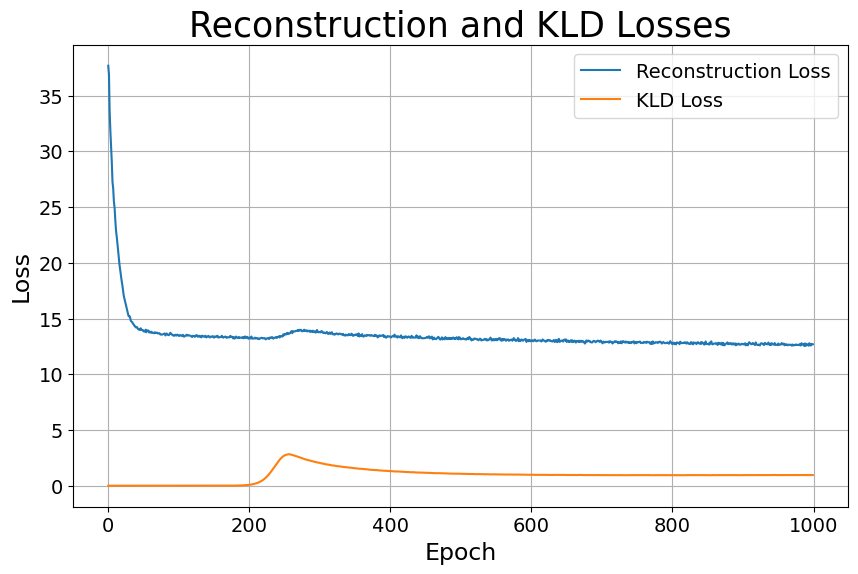

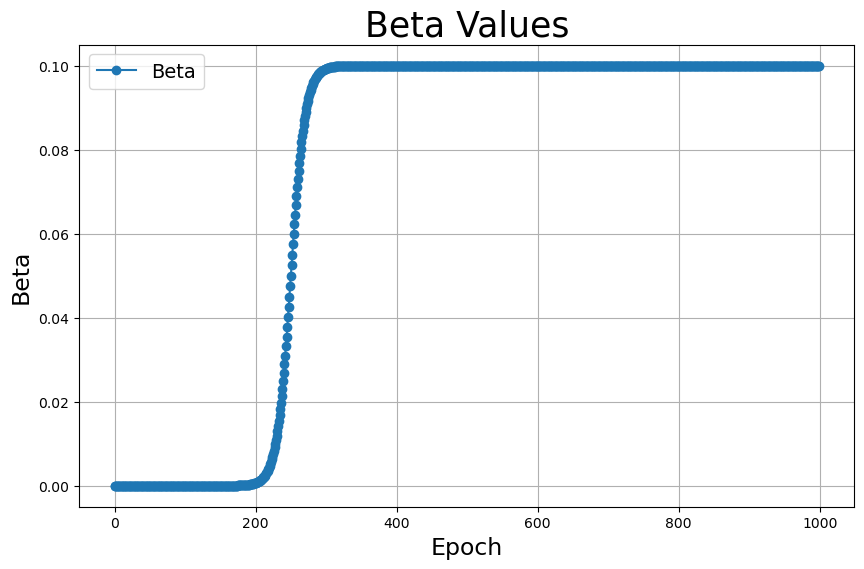

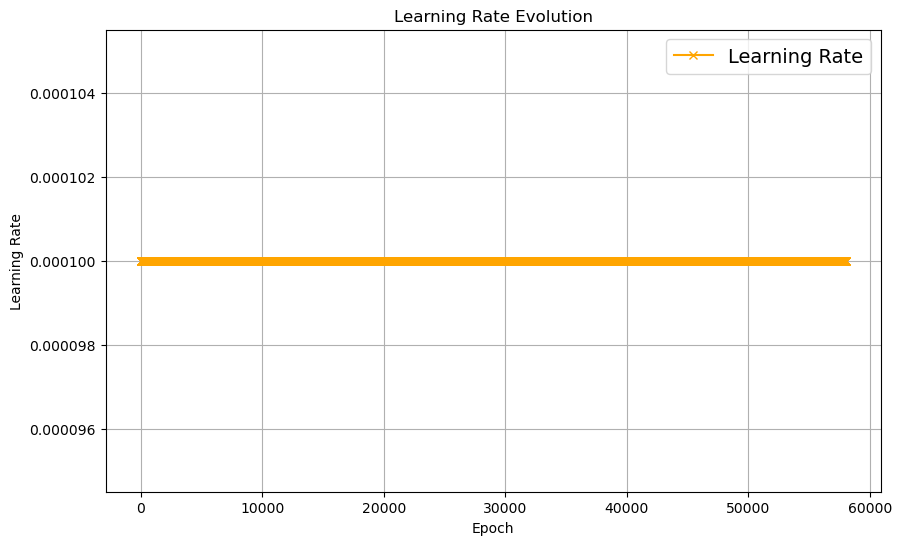

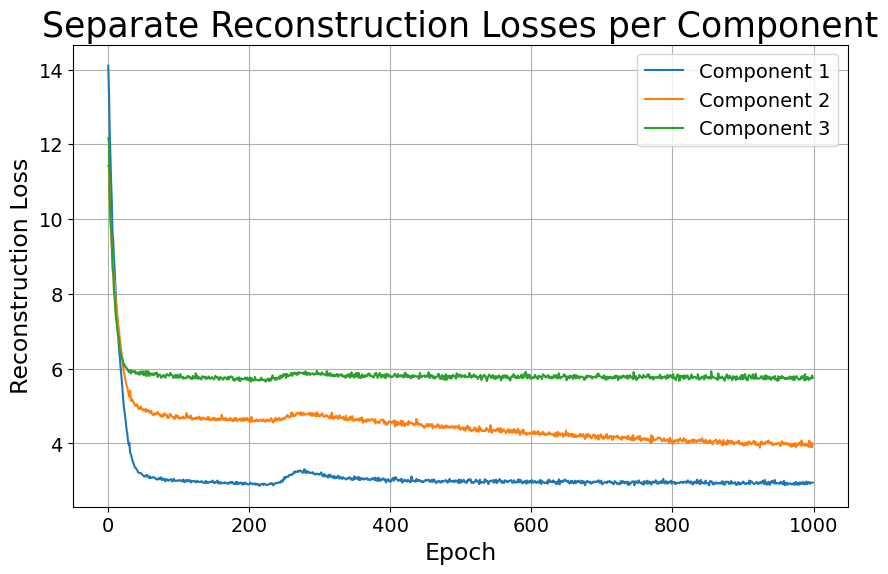

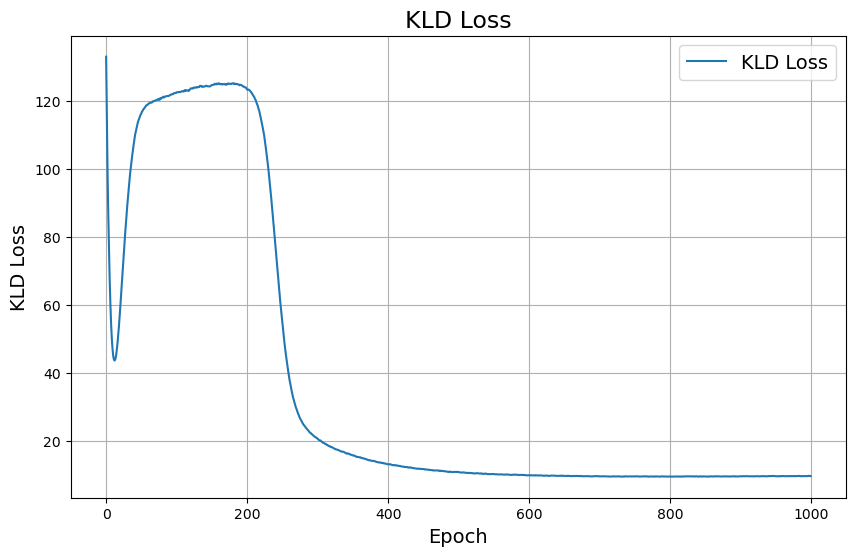

In [4]:
vae_file_path = os.path.join('..',"Def Models", f"{model_name}.pth")
vae_model, vae_checkpoint = load_vae(vae_file_path,decoder_layers,encoder_layers, Decoder, Encoder, VAE)

train_losses = vae_checkpoint['train_losses']
val_losses = vae_checkpoint['val_losses']
recon_losses = vae_checkpoint['recon_losses']
kld_losses = vae_checkpoint['kld_losses']
effective_kld_losses = vae_checkpoint['effective_kld_losses']
beta_values = vae_checkpoint['beta_values']
gradient_history = vae_checkpoint['gradient_history']
lr_evolution = vae_checkpoint['lr_evolution']
separate_recon_losses = vae_checkpoint['separate_recon_losses']

# Loss Curves Figure
fig = plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch',fontsize=17)
plt.ylabel('Loss',fontsize=17)
plt.title('Loss Curves', fontsize=25)
plt.legend(fontsize = 14)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

# Gradient Norm Evolution Figure
fig = plt.figure(figsize=(10, 6))
epochs_grad = range(len(gradient_history["encoder"]))
#plt.plot(epochs_grad, gradient_history["encoder"], label="Encoder Gradient Norm")
plt.plot(epochs_grad, gradient_history["decoder"], label="Decoder Gradient Norm", alpha = 0.8)
plt.plot(epochs_grad, gradient_history["latent"], label="Latent Gradient Norm", alpha = 0.8)
plt.xlabel("Epoch",fontsize=14)
plt.ylabel("Gradient Norm",fontsize=14)
plt.title("Gradient Norm Evolution",fontsize=17)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()

# Reconstruction & Effective KLD Losses Figure
fig = plt.figure(figsize=(10, 6))
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(effective_kld_losses, label='KLD Loss')
plt.xlabel('Epoch',fontsize=17)
plt.ylabel('Loss',fontsize=17)
plt.title('Reconstruction and KLD Losses',fontsize=25)
plt.legend(fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
plt.show()

# Beta Values Figure
fig = plt.figure(figsize=(10, 6))
plt.plot(beta_values, label='Beta', marker='o')
plt.xlabel('Epoch',fontsize=17)
plt.ylabel('Beta',fontsize=17)
plt.title('Beta Values',fontsize=25)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()

# Learning Rate Evolution Figure
fig = plt.figure(figsize=(10, 6))
plt.plot(lr_evolution, label='Learning Rate', color='orange', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Evolution')
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()

# Separate Reconstruction Losses per Component Figure
fig = plt.figure(figsize=(10, 6))
array_separate_recon = np.array(separate_recon_losses)
for i in range(n_components):
    plt.plot(array_separate_recon[:, i], label=f'Component {i+1}')
plt.xlabel('Epoch',fontsize=17)
plt.ylabel('Reconstruction Loss',fontsize=17)
plt.title('Separate Reconstruction Losses per Component',fontsize=25)
plt.legend(fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
plt.show()

# KLD Loss Figure
fig = plt.figure(figsize=(10, 6))
plt.plot(kld_losses, label='KLD Loss')
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('KLD Loss',fontsize=14)
plt.title('KLD Loss',fontsize=17)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()


### Load Dataset

In [ ]:
image_name = 'rs-fmri-'
input_folder = 'Compressed Data'

lag_path = os.path.join('..', 'best_lags.npy')
corr_path = os.path.join('..', 'best_corrs.npy')
lag_list = np.load(lag_path)
corr_list = np.load(corr_path)

print('lag shape:', lag_list.shape)
print('corr shape:', corr_list.shape)

indices = np.array(index) - 1
lag_list = lag_list[indices]
corr_list = corr_list[indices]

pupil_name = 'pupil_diameter_74_trials.npy'
pupil_name = os.path.join('..', pupil_name)
pupil = np.load(pupil_name)
pupil = pupil[indices, :]

selected_pupil = []

def load_datasets(image_name, input_folder, index_list, threshold=0.5, max_lag=10):
    dataset_list = []
    voxel_list = []
    for idx in index_list:
        if (abs(corr_list[np.where(indices== (idx-1))[0][0]]) > threshold) and (abs(lag_list[np.where(indices== (idx-1))[0][0]]) < max_lag):
            file_name = f"{image_name}{idx}.npz"
            file_path = os.path.join('..', input_folder, file_name)
            selected_pupil.append(pupil[np.where(indices==(idx-1))[0][0], :])
            try:
                data = np.load(file_path)
                sliced_data_res = data['functional_data_res']
                active_voxel_indices = data['active_voxel_indices']
                dataset_list.append(sliced_data_res)
                voxel_list.append(active_voxel_indices)
                print(f"Caricato: {file_name} con shape {sliced_data_res.shape} e correlazione: {corr_list[np.where(indices==(idx-1))[0][0]]} e lag: {lag_list[np.where(indices==(idx-1))[0][0]]}")
            except Exception as e:
                print(f"Errore nel caricamento di {file_name}: {e}")
        else:
            print(f"Saltato: {image_name}{idx}.npz perché corr_list[{idx-1}] = {corr_list[np.where(indices==(idx-1))[0][0]]} non supera la soglia {threshold}")
    if dataset_list:
        dataset_array = np.stack(dataset_list, axis=0)
        voxel_array = np.stack(voxel_list)
    else:
        dataset_array = None
    return dataset_array, voxel_array

decoder_dataset, active_voxels_indices = load_datasets(image_name, input_folder, index, threshold=min_corr, max_lag = max_lag)
active_voxels = decoder_dataset.shape[1]


pupil = np.array(selected_pupil)

range_set = pupil.shape[0]

print(f"Shape finale del dataset: {decoder_dataset.shape}")
print(f"Shape finale del dataset pupil: {pupil.shape}")

# Isolating frequencies from data:
# Filtering the signal
fmin = 0.01
fmax = 0.05

pupil_filtered = filter_pupil_signal(pupil, fmin, fmax)
print('pupil_filtered shape:', pupil_filtered.shape)


lag shape: (73,)
corr shape: (73,)
Caricato: rs-fmri-2.npz con shape (21680, 925) e correlazione: -0.6455383874964343 e lag: 13
Caricato: rs-fmri-3.npz con shape (21680, 925) e correlazione: -0.7350390751899801 e lag: 15
Caricato: rs-fmri-4.npz con shape (21680, 925) e correlazione: -0.7865553100001432 e lag: 12
Shape finale del dataset: (3, 21680, 925)
Shape finale del dataset pupil: (3, 925)
pupil_filtered shape: (3, 925)


### fmri's PC

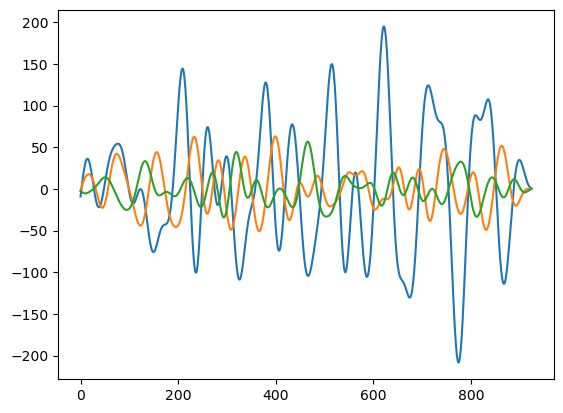

Set 1 - Varianza spiegata cumulativa: [0.5115651  0.5765354  0.62244815]


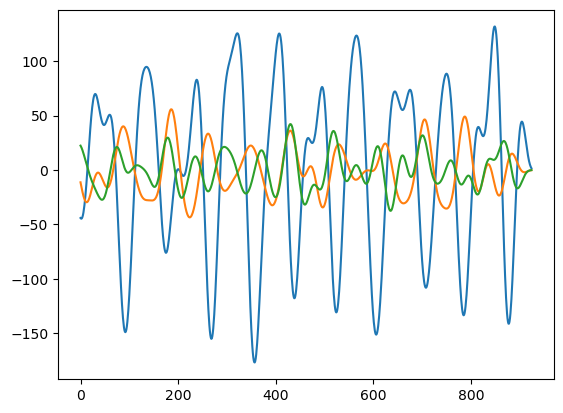

Set 2 - Varianza spiegata cumulativa: [0.5094693  0.56925887 0.6194017 ]


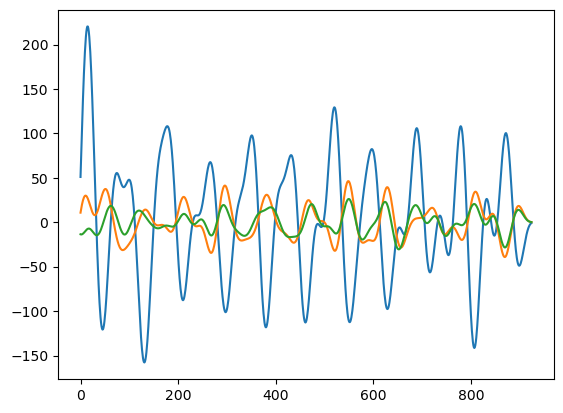

Set 3 - Varianza spiegata cumulativa: [0.4681305 0.5291144 0.578283 ]
tau_crit: 41.57596265995842
tau_crit: 34.91572561813477
tau_crit: 35.88170908297147
Dataset 1 - Correlazione tra PC1 e pupil: -0.3459946102223071
tau_crit: 42.36311054523527
tau_crit: 42.64795748450488
tau_crit: 35.6469640304077
Dataset 2 - Correlazione tra PC1 e pupil: -0.3334067106386163
tau_crit: 38.780655514107366
tau_crit: 38.709405399607355
tau_crit: 36.90728580598615
Dataset 3 - Correlazione tra PC1 e pupil: -0.37383639774379523
Actual time window:  38
PC dataset shape: (3, 3, 925)
tau_crit pupil: 47.43437232283478
tau_crit pupil: 43.82667226217678
tau_crit pupil: 42.237786073879136


In [ ]:
PC_dataset = []
PCA_transformation = []
norm_params = []   
var_explained = []

for i in range(range_set):
   
    pca = PCA(n_components=n_components)
    y = pca.fit_transform(decoder_dataset[i].T)
    
    # Applica il filtro bandpass
    b, a = butter(4, [fmin, fmax], 'bandpass')
    y_filtered = filtfilt(b, a, y, padlen=10, axis=0)

    plt.plot(y_filtered)
    plt.show()
    
    # Lista per il set corrente, per salvare i parametri di normalizzazione per ogni componente
    norm_params_set = []
    
    # Normalizza each componente (zscore) salvando media e std per poter invertire la normalizzazione
    for j in range(n_components):
        mu = np.mean(y_filtered[:, j])
        std = np.std(y_filtered[:, j])
        norm_params_set.append((mu, std))
        y_filtered[:, j] = (y_filtered[:, j] - mu) / std  # Normalizzazione z-score
        
    norm_params.append(norm_params_set)
    
    # Salva il risultato della PCA (con i dati normalizzati) e l'oggetto PCA
    PC_dataset.append(y_filtered.T)
    PCA_transformation.append(pca)
    
    # Calcola e mostra il cumulativo della varianza spiegata per questo set
    explained_variance = pca.explained_variance_ratio_
    cumul_explained = np.cumsum(explained_variance)
    var_explained.append(cumul_explained)
    print(f'Set {i+1} - Varianza spiegata cumulativa: {cumul_explained}')

# Converti PC_dataset in array numpy se necessario
PC_dataset = np.array(PC_dataset)
var_explained = np.array(var_explained)

tau_crit = np.zeros((range_set, n_components))
for i in range(range_set):
    for j in range(n_components):
        _, _, time_window = compute_tau_critical(PC_dataset[i, j, :], dt=1.0)
        tau_crit[i, j] = time_window
        print('tau_crit:', time_window)
    # Calcola l'indice di correlazione tra PC1 e il pupil corrispondente per il dataset i
    corr_pc1_pupil = np.corrcoef(PC_dataset[i, 0, :], pupil_filtered[i, :])[0, 1]
    print(f'Dataset {i+1} - Correlazione tra PC1 e pupil: {corr_pc1_pupil}')

print('Actual time window: ', (embedding_dim-1)*tau)
print('PC dataset shape:', PC_dataset.shape)


for i in range(range_set):
    _,_,time_window = compute_tau_critical(pupil_filtered[i,:], dt=1.0)
    print('tau_crit pupil:', time_window)

### Lag Correction

In [7]:
# Calcola i valori massimi dei lag (positive e negative) e la shape finale (numero di time steps dopo shifting)
print('Lag_list shape:', lag_list.shape)
print('Corr_list shape:', corr_list.shape)

L_max_pos = max([lag for lag in lag_list if lag > 0] or [0])
L_max_neg = max([-lag for lag in lag_list if lag < 0] or [0])

print('L_max_pos:', L_max_pos)
print('L_max_neg:', L_max_neg)

final_shape = 925 - (L_max_pos - L_max_neg)  # Shape finale per pupil_filtered ed altri array
print('Final shape:', final_shape)

# Inizializza gli array dummy per pupil, PC e decoder
pupil_dummy = np.zeros((range_set, final_shape))
PC_dummy = np.zeros((range_set, n_components, final_shape))
decoder_dummy = np.zeros((range_set, active_voxels, final_shape))

correlation_list = []

for i in range(range_set):
    # Shift per pupil e PC (già esistente)
    if lag_list[i] < 0:
        shifted_p = pupil_filtered[i, :lag_list[i]]
        shifted_pc = PC_dataset[i, :, -lag_list[i]:]
    if lag_list[i] >= 0:
        shifted_p = pupil_filtered[i, lag_list[i]:]
        shifted_pc = PC_dataset[i, :, :len(pupil_filtered[i, lag_list[i]:])]
        
    if len(shifted_p) > 1 and len(shifted_p) == shifted_pc.shape[1]:
        corr = np.corrcoef(shifted_p, shifted_pc[0, :])[0, 1]
        print(f'Correlazione tra pupil e PC1 con lag: {lag_list[i]}: {corr}')
    
    # Rimuovi la differenza con il max lag (per avere tutti la stessa lunghezza)
    max_dif = abs(lag_list[i] - L_max_pos)
    min_dif = abs(lag_list[i] - L_max_neg)
    
    if lag_list[i] > 0:  # se lag > 0, rimuovi i primi max_dif campioni
        shifted_p = shifted_p[max_dif:]
        shifted_pc = shifted_pc[:, max_dif:]
    if lag_list[i] < 0:  # se lag < 0, rimuovi gli ultimi min_dif campioni
        shifted_p = shifted_p[:-min_dif]
        shifted_pc = shifted_pc[:, :-min_dif]
        
    if len(shifted_p) > 1 and len(shifted_p) == shifted_pc.shape[1]:
        corr = np.corrcoef(shifted_p, shifted_pc[0, :])[0, 1]
        correlation_list.append(corr)
        print(f'Correlazione tra pupil e PC1 dopo rimozione: {lag_list[i]}: {corr}')
        
    pupil_dummy[i] = shifted_p
    PC_dummy[i] = shifted_pc

    # Ora shiftiamo decoder_dataset con la stessa logica:
    # Se il lag è negativo, prendi gli elementi fino all'indice lag_list[i] (che, essendo negativo, esclude gli ultimi abs(lag) elementi);
    # se il lag è positivo, prendi dal lag in poi.
    if lag_list[i] < 0:
        shifted_dec = decoder_dataset[i, :, :lag_list[i]]
    if lag_list[i] >= 0:
        shifted_dec = decoder_dataset[i, :, lag_list[i]:]
    
    # Applica la rimozione differenziale per avere la stessa lunghezza
    if lag_list[i] > 0:
        shifted_dec = shifted_dec[:, max_dif:]
    if lag_list[i] < 0:
        shifted_dec = shifted_dec[:, :-min_dif]
    
    # Assegna gli array shifted al decoder_dummy
    decoder_dummy[i] = shifted_dec

# Aggiorna i dati con le versioni allineate
PC_dataset = PC_dummy
pupil_filtered = pupil_dummy
decoder_dataset = decoder_dummy

print('PC dataset shape:', PC_dataset.shape)
print('Pupil shape:', pupil_filtered.shape)
print('Decoder dataset shape:', decoder_dataset.shape)

Lag_list shape: (3,)
Corr_list shape: (3,)
L_max_pos: 15
L_max_neg: 0
Final shape: 910
Correlazione tra pupil e PC1 con lag: 13: -0.6455378230966411
Correlazione tra pupil e PC1 dopo rimozione: 13: -0.6456629363834099
Correlazione tra pupil e PC1 con lag: 15: -0.735039204211712
Correlazione tra pupil e PC1 dopo rimozione: 15: -0.735039204211712
Correlazione tra pupil e PC1 con lag: 12: -0.7865551568058831
Correlazione tra pupil e PC1 dopo rimozione: 12: -0.7859099597672741
PC dataset shape: (3, 3, 910)
Pupil shape: (3, 910)
Decoder dataset shape: (3, 21680, 910)


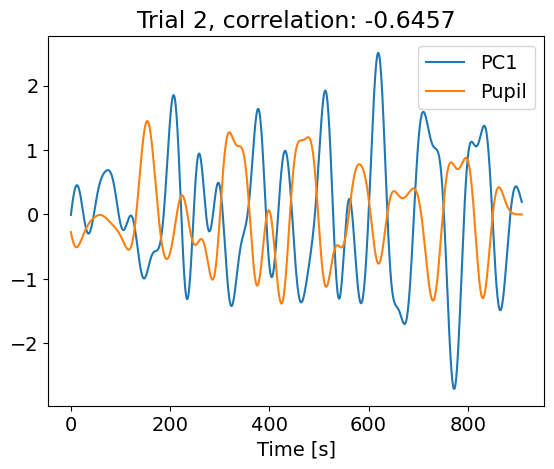

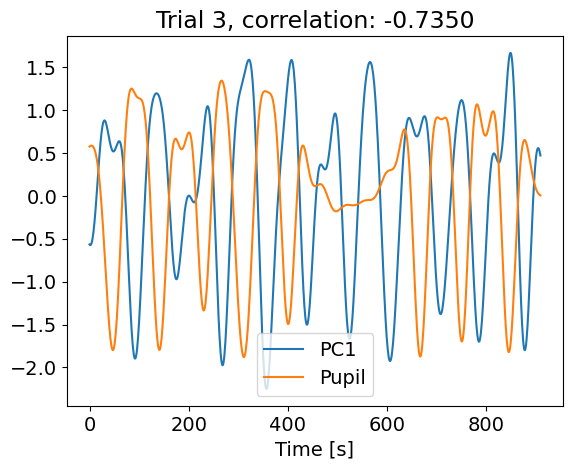

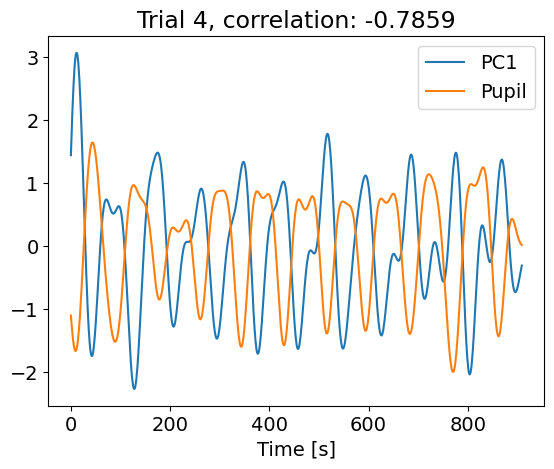

In [8]:
correlation_list = np.array(correlation_list)
for i in range(range_set):
        plt.plot(PC_dataset[i,0,:], label = 'PC1')
        plt.plot(pupil_filtered[i,:], label = 'Pupil')
        plt.title(f'Trial {index[i]}, correlation: {correlation_list[i]:.4f}',fontsize = 17)
        plt.xlabel('Time [s]',fontsize = 14)
        plt.legend(fontsize = 14)
        plt.tick_params(axis='both', which='major', labelsize=14)
        plt.show()

### Pupil Embeddings:

In [9]:
#Embeddding preparation
hankel_matrix = []
projected_hankel_matrix = []

pupil_filtered = zscore(pupil_filtered, axis=-1)
for i in range(range_set):
    hankel_matrix.append(create_time_delay_embedding(data=pupil_filtered[i,:], delay=tau,embedding_dim=embedding_dim).T)

hankel_matrix = np.array(hankel_matrix)
print('Hankel matrix shape:', hankel_matrix.shape)

P = legendre_basis(embedding_dim,r)
print('Legendre basis Matrix shape:', P.shape)

for i in range(range_set):
    projected_hankel_matrix.append(np.dot(hankel_matrix[i].T,P).T)

projected_hankel_matrix = np.array(projected_hankel_matrix)
print('Projected Hankel matrix shape:', projected_hankel_matrix.shape)


# Normalization of Legendre coordinates over their time series
'''
for i in range(range_set):
  for j in range(r): 
    projected_hankel_matrix[i,j,:] = zscore(projected_hankel_matrix[i,j,:])
'''
    
#Extracting training data, validation data and test data

total_size = int(projected_hankel_matrix.shape[2])
train_index = int(0.70 * total_size)  # 60% per il training
val_index = int( train_index + 0.15 * total_size)    # 20% per la validazione
test_index = int(val_index + 0.15 * total_size)   # 20% per il test and it is equal to num_samples 
print('Indexes:', train_index, val_index, test_index)

train_matrix = projected_hankel_matrix[:,:,0:(train_index)]
val_matrix = projected_hankel_matrix[:,:,train_index:(val_index)]
test_matrix = projected_hankel_matrix[:,:,val_index:(test_index)]

train_time_start = 0
train_time_end = (train_index-1) + (embedding_dim-1)*tau
val_time_start = train_index 
val_time_end = (val_index-1) + (embedding_dim-1)*tau
test_time_start = val_index
test_time_end = (test_index-1) + (embedding_dim-1)*tau


print('########################################')
print('TIME STEP FOR SERIES:')
print('Train i-f:', train_time_start,' - ',train_time_end)
print('Val i-f:', val_time_start,' - ',val_time_end)
print('Test i-f:', test_time_start,' - ',test_time_end)
print('########################################')


legendre_test_matrix_norm = test_matrix

print('Original Matrix shape (range_set,r,n_sample):')
print('Train:', train_matrix.shape)
print('Val:', val_matrix.shape)
print('Test:', test_matrix.shape)

# Transposing the matrices to allign time series
train_matrix = np.transpose(train_matrix, (1, 0, 2))
val_matrix = np.transpose(val_matrix, (1, 0, 2))
test_matrix = np.transpose(test_matrix, (1, 0, 2))

print('Transposed Matrix shape (r,range_set,n_samples):')
print('Train:', train_matrix.shape)
print('Val:', val_matrix.shape)
print('Test:', test_matrix.shape)

train_matrix = train_matrix.reshape(r, -1)
val_matrix = val_matrix.reshape(r, -1)
test_matrix = test_matrix.reshape(r, -1)

print('Flattened Matrix shape (r, range_set*num_samples):') 
print('Train:', train_matrix.shape)
print('Val:', val_matrix.shape)
print('Test:', test_matrix.shape)


Hankel matrix shape: (3, 20, 872)
Legendre basis Matrix shape: (20, 15)
Projected Hankel matrix shape: (3, 15, 872)
Indexes: 610 740 870
########################################
TIME STEP FOR SERIES:
Train i-f: 0  -  647
Val i-f: 610  -  777
Test i-f: 740  -  907
########################################
Original Matrix shape (range_set,r,n_sample):
Train: (3, 15, 610)
Val: (3, 15, 130)
Test: (3, 15, 130)
Transposed Matrix shape (r,range_set,n_samples):
Train: (15, 3, 610)
Val: (15, 3, 130)
Test: (15, 3, 130)
Flattened Matrix shape (r, range_set*num_samples):
Train: (15, 1830)
Val: (15, 390)
Test: (15, 390)


### fmri Embeddings:

In [10]:
fmri_embedding_pc = []
fmri_embedding_set = []
fmri_projected_pc = []
fmri_projected_set = []

# Embedding preparation
for i in range(range_set): # 0 2
    for j in range(n_components): # 0 5
        fmri_embedding_pc.append(create_time_delay_embedding(data=PC_dataset[i,j,:], delay=tau,embedding_dim=embedding_dim).T)
    
    fmri_embedding_set.append(np.array(fmri_embedding_pc))
    fmri_embedding_pc = []

fmri_embedding_set = np.array(fmri_embedding_set)
print('Fmri embedding shape (set, n_components, embedding_dim, n_samples):', fmri_embedding_set.shape)


embedded_train_matrix = fmri_embedding_set[:,:,:,0:(train_index)]
embedded_val_matrix = fmri_embedding_set[:,:,:,train_index:(val_index)]
embedded_test_matrix = fmri_embedding_set[:,:,:,val_index:(test_index)]

# Projecting the Hankel matrix for every components

for i in range(range_set):
    for j in range(n_components):
        fmri_projected_pc.append(np.dot(fmri_embedding_set[i,j].T,P).T)
    
    fmri_projected_set.append(np.array(fmri_projected_pc))
    fmri_projected_pc = []


fmri_projected_set = np.array(fmri_projected_set)
print('Fmri projected shape (set, n_components, r, n_samples):', fmri_projected_set.shape)

# Normalization of Legendre coordinates over their time series

'''for i in range(range_set):
    for j in range(n_components):
        for k in range(r):
            fmri_projected_set[i,j,k,:] = zscore(fmri_projected_set[i,j,k,:])

'''
# Creation of training, validation and test set
train_fmri = fmri_projected_set[:,:,:,0:(train_index)]
val_fmri = fmri_projected_set[:,:,:,train_index:(val_index)]
test_fmri = fmri_projected_set[:,:,:,val_index:(test_index)]

print('Original Matrix shape (range_set,n_components,r,n_sample):')
print('Train fmri shape:', train_fmri.shape)
print('Val fmri shape:', val_fmri.shape)
print('Test fmri shape:', test_fmri.shape)

# Transposing the matrices to allign time series (n_components,r,range_set,n_samples) -> (1,2,0,3)

train_fmri = np.transpose(train_fmri, (1, 2, 0, 3))
val_fmri = np.transpose(val_fmri, (1, 2, 0, 3))
test_fmri = np.transpose(test_fmri, (1, 2, 0, 3))

print('Transposed Matrix shape (n_components,r,range_set,n_samples):')
print('Train fmri shape:', train_fmri.shape)
print('Val fmri shape:', val_fmri.shape)
print('Test fmri shape:', test_fmri.shape)

# Flattening the matrices along samples and range (n_components,r,range_set*num_samples)

train_fmri = train_fmri.reshape(n_components, r, -1)
val_fmri = val_fmri.reshape(n_components, r, -1)
test_fmri = test_fmri.reshape(n_components, r, -1)

print('Flattened Matrix shape (n_components,r,range_set*num_samples):')
print('Train fmri shape:', train_fmri.shape)
print('Val fmri shape:', val_fmri.shape)
print('Test fmri shape:', test_fmri.shape)

# Flattening the matrices along n_components and r meglio after training coosì calcoli loss separate
#Do come target il non flatten e inverto la trasformazione del reconstructed (che invece è flattenato)

Fmri embedding shape (set, n_components, embedding_dim, n_samples): (3, 3, 20, 872)
Fmri projected shape (set, n_components, r, n_samples): (3, 3, 15, 872)
Original Matrix shape (range_set,n_components,r,n_sample):
Train fmri shape: (3, 3, 15, 610)
Val fmri shape: (3, 3, 15, 130)
Test fmri shape: (3, 3, 15, 130)
Transposed Matrix shape (n_components,r,range_set,n_samples):
Train fmri shape: (3, 15, 3, 610)
Val fmri shape: (3, 15, 3, 130)
Test fmri shape: (3, 15, 3, 130)
Flattened Matrix shape (n_components,r,range_set*num_samples):
Train fmri shape: (3, 15, 1830)
Val fmri shape: (3, 15, 390)
Test fmri shape: (3, 15, 390)


### Dataset creation

In [11]:
# Crea il dataset
train_dataset = EmbeddedDatasetforDecoder(train_matrix, train_fmri)
val_dataset = EmbeddedDatasetforDecoder(val_matrix, val_fmri)
test_dataset = EmbeddedDatasetforDecoder(test_matrix, test_fmri)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepara il DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Debug del batch
for batch in train_loader:
    inputs, targets = batch  # Decomponi input e target
    inputs = inputs.float()
    targets = targets.float()
    print("Shape of input:", inputs.shape) # Batch size x r (dimensione del singolo sample di y1)
    print("Shape of target:", targets.shape) # Batch size x 2*r (dimensione del singolo sample di y2)
    break

Shape of input: torch.Size([32, 15])
Shape of target: torch.Size([32, 45])


### Networks Output:

In [12]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
#########################################################################
loader = test_loader
dataset = test_dataset
embedded_matrix = embedded_test_matrix

time_series_start = test_time_start
time_series_end = test_time_end

print('##################################################################')
print('Time series indexes:', time_series_start, time_series_end)
print('Time series sample = ', time_series_end - time_series_start)


decoder_dataset_dummy = decoder_dataset[:,:,time_series_start:time_series_end+1]
pupil_signal = pupil_filtered[:,time_series_start:time_series_end+1]
PC_signal = PC_dataset[:,:,time_series_start:time_series_end+1]

print('Decoder dataset shape:', decoder_dataset_dummy.shape)
print('Pupil signal shape:', pupil_signal.shape)
print('PC signal shape:', PC_signal.shape)
print('##################################################################')
##########################################################################

inputs, targets, predicted_data, mean_vectors, logvar_vectors = run_model_and_collect_outputs(vae_model, loader, device=device, n_components=n_components, r=r) 
#inputs = dataset.input_data
#targets = dataset.target_data

n_samples = predicted_data.shape[0]


print('Embedded Matrix Shape:', embedded_matrix.shape)


print('##################################################################')
print('type inputs:', type(inputs))
print('type targets:', type(targets))
print('type predicted_data:', type(predicted_data))
print('###################################################################')


print("Input data shape:", inputs.shape)
print("target data shape (n_sample, n_components, r):" , targets.shape)
print("VAE Predicted data shape (n_sample, n_components, r):", predicted_data.shape)

print("Mean vectors shape:", mean_vectors.shape)
print("Logvar vectors shape:", logvar_vectors.shape)


print ('#################################################################')

for i in range(n_components):
    vae_mse =mean_squared_error(predicted_data[:,i,:],targets[:,i,:])  
    print('Component ', i+1)
    print(f'VAE Model MSE: {vae_mse:.4f}')

##################################################################
Time series indexes: 740 907
Time series sample =  167
Decoder dataset shape: (3, 21680, 168)
Pupil signal shape: (3, 168)
PC signal shape: (3, 3, 168)
##################################################################
Embedded Matrix Shape: (3, 3, 20, 130)
##################################################################
type inputs: <class 'numpy.ndarray'>
type targets: <class 'numpy.ndarray'>
type predicted_data: <class 'numpy.ndarray'>
###################################################################
Input data shape: (390, 15)
target data shape (n_sample, n_components, r): (390, 3, 15)
VAE Predicted data shape (n_sample, n_components, r): (390, 3, 15)
Mean vectors shape: (390, 10)
Logvar vectors shape: (390, 10)
#################################################################
Component  1
VAE Model MSE: 45.4340
Component  2
VAE Model MSE: 10.5224
Component  3
VAE Model MSE: 7.8759


In [13]:
# Evaluation of the model between input and output:

for i in range(n_components):

    print('#################################################################')    
    r2_vae = r2_score(targets[:,i,:].flatten(), predicted_data[:,i,:].flatten())
    print(f"PC{i+1} - R2 score:", r2_vae)

print('#################################################################')

#################################################################
PC1 - R2 score: 0.11495721340179443
#################################################################
PC2 - R2 score: -6.86587381362915
#################################################################
PC3 - R2 score: -2.609581708908081
#################################################################


In [14]:
# Inversione del flatten sui database:

predicted_data = predicted_data.transpose(1,2,0)
targets = targets.transpose(1,2,0)
inputs = inputs.T


print('#################################################################')
print("Predicted data shape (n_components, r, n_samples):", predicted_data.shape)
print("Targets shape (n_components, r, n_samples):", targets.shape)
print("Input data shape (r, n_samples):", inputs.shape)
print('#################################################################')

# Reshape per ritornare alla forma: (n_components, r, range_set, samples_set)

predicted_data = predicted_data.reshape(n_components, r, range_set, -1)
targets = targets.reshape(n_components, r, range_set, -1)
inputs = inputs.reshape(r, range_set, -1)


print('#################################################################')
print("Predicted data shape (n_components, r, range_set, samples_set):", predicted_data.shape)
print("Targets shape (n_components, r, range_set, samples_set):", targets.shape)
print("Input data shape (r, range_set, samples_set):", inputs.shape)
print('#################################################################')

# Trasposizione per ritornare a (range_set, n_components, r, samples_set)
predicted_data = predicted_data.transpose(2,0,1,3)
targets = targets.transpose(2,0,1,3)
inputs = inputs.transpose(1,0,2)

test_sample = targets.shape[3]

print('#################################################################')
print("Predicted data shape (range_set, n_components, r, samples_set):", predicted_data.shape)
print("Targets shape (range_set, n_components, r, samples_set):", targets.shape)
print("Input data shape (range_set, r, samples_set):", inputs.shape)
print('#################################################################')


#################################################################
Predicted data shape (n_components, r, n_samples): (3, 15, 390)
Targets shape (n_components, r, n_samples): (3, 15, 390)
Input data shape (r, n_samples): (15, 390)
#################################################################
#################################################################
Predicted data shape (n_components, r, range_set, samples_set): (3, 15, 3, 130)
Targets shape (n_components, r, range_set, samples_set): (3, 15, 3, 130)
Input data shape (r, range_set, samples_set): (15, 3, 130)
#################################################################
#################################################################
Predicted data shape (range_set, n_components, r, samples_set): (3, 3, 15, 130)
Targets shape (range_set, n_components, r, samples_set): (3, 3, 15, 130)
Input data shape (range_set, r, samples_set): (3, 15, 130)
#################################################################


In [15]:
# Inizializza l'array per i r2 score con la forma corretta:
r2_sets = np.zeros((range_set, n_components, test_sample))

for i in range(range_set):
    for j in range(n_components):
        for k in range(test_sample):
            r2_sets[i, j, k] = r2_score(targets[i, j, :, k], predicted_data[i, j, :, k])

for i in range(range_set):

    print('################################################################')
    for j in range(n_components):

        print(f"PC {j+1} set {i+1} - R2 VAE: {np.mean(r2_sets[i, j, :])}")
    print('################################################################')
        #plt.hist(r2_sets[i, j, :], bins=20)
        #plt.title(f"R2 Component {j+1} Set {i+1}")
        #plt.show()

            

################################################################
PC 1 set 1 - R2 VAE: 0.06261158952346214
PC 2 set 1 - R2 VAE: -8.859879904068434
PC 3 set 1 - R2 VAE: -3.214061372096722
################################################################
################################################################
PC 1 set 2 - R2 VAE: 0.07632191960628217
PC 2 set 2 - R2 VAE: -12.863727951049805
PC 3 set 2 - R2 VAE: -4.811426014166612
################################################################
################################################################
PC 1 set 3 - R2 VAE: -0.08447789503977848
PC 2 set 3 - R2 VAE: -23.61107896566391
PC 3 set 3 - R2 VAE: -7.855804944955386
################################################################


### Dimensionality recover

In [16]:
# Pseudo-inverse evaluation
P_pseudo_inverse = pinv(P)  


print('targets shape:', targets.shape)

rev_predicted_data = np.zeros((range_set, n_components, embedding_dim, test_sample))
rev_target_data = np.zeros((range_set, n_components, embedding_dim, test_sample))
rev_input_data = np.zeros((range_set, embedding_dim, test_sample))


for i in range(range_set):
    for j in range(n_components):
        rev_predicted_data[i,j,:,:] = np.dot(predicted_data[i,j,:,:].T, P_pseudo_inverse).T
        rev_target_data[i,j,:,:] = np.dot(targets[i,j,:,:].T, P_pseudo_inverse).T
    rev_input_data[i,:,:] = np.dot(inputs[i,:,:].T, P_pseudo_inverse).T
print('rev_predicted_data shape:', rev_predicted_data.shape)
print('original data shape:', embedded_matrix.shape)
print('rev_target_data shape:', rev_target_data.shape)
print('rev_input_data shape:', rev_input_data.shape)



# r2 after inversion for dataset:

print('#################################################################')
print(' R2 between target and predicted data after inversion:')
for i in range(range_set):
    for j in range(n_components):
        r2_vae = r2_score(rev_target_data[i,j], rev_predicted_data[i,j])
        print(f"Dataset {i+1}, PC {j+1} - R2 VAE: {r2_vae:.4f}")


print('#################################################################')
print(' R2 between target and original embeddings after target inversion:')
for i in range(range_set):
    r2_inversion = r2_score(rev_target_data[i,j], embedded_matrix[i,j])
    print(f"Dataset {i+1}, PC {j+1} - R2 after inversion: {r2_inversion:.4f}")
print('#################################################################')


targets shape: (3, 3, 15, 130)
rev_predicted_data shape: (3, 3, 20, 130)
original data shape: (3, 3, 20, 130)
rev_target_data shape: (3, 3, 20, 130)
rev_input_data shape: (3, 20, 130)
#################################################################
 R2 between target and predicted data after inversion:
Dataset 1, PC 1 - R2 VAE: -0.0221
Dataset 1, PC 2 - R2 VAE: -0.8595
Dataset 1, PC 3 - R2 VAE: -0.3202
Dataset 2, PC 1 - R2 VAE: -0.0598
Dataset 2, PC 2 - R2 VAE: -0.9905
Dataset 2, PC 3 - R2 VAE: -0.4485
Dataset 3, PC 1 - R2 VAE: 0.0119
Dataset 3, PC 2 - R2 VAE: -1.9278
Dataset 3, PC 3 - R2 VAE: -0.7631
#################################################################
 R2 between target and original embeddings after target inversion:
Dataset 1, PC 3 - R2 after inversion: -0.8996
Dataset 2, PC 3 - R2 after inversion: -1.1682
Dataset 3, PC 3 - R2 after inversion: -2.5391
#################################################################


### Time series reconstruction

n_time_step: 168


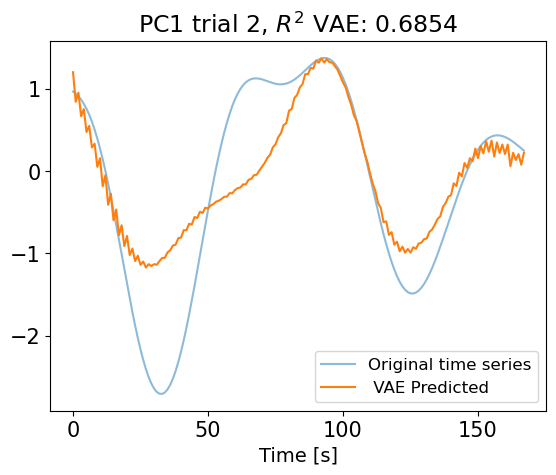

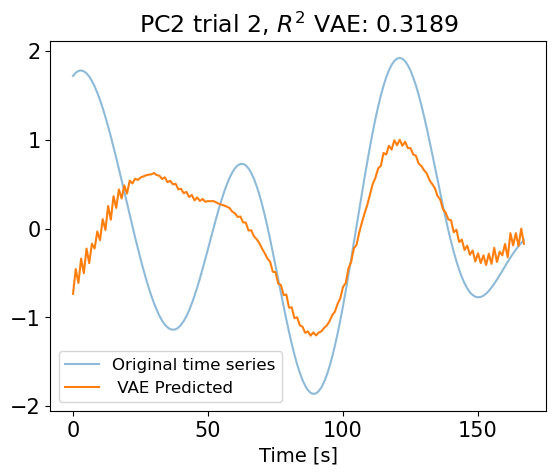

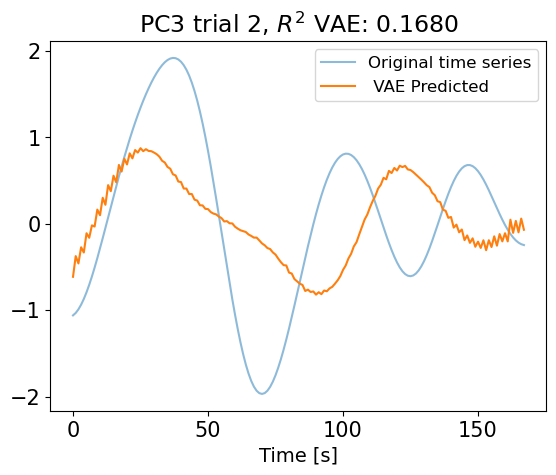

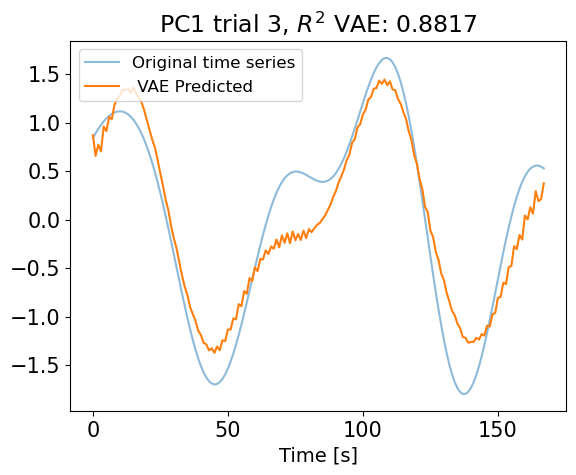

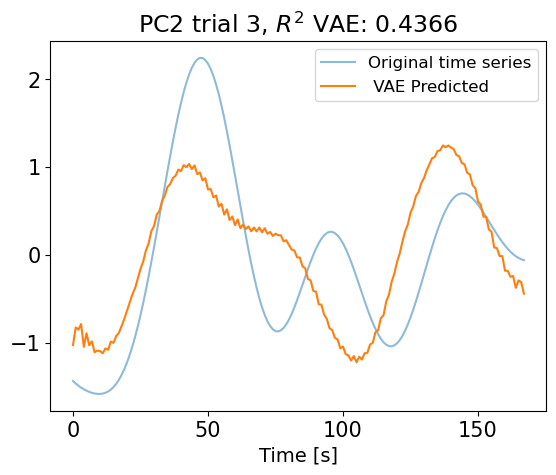

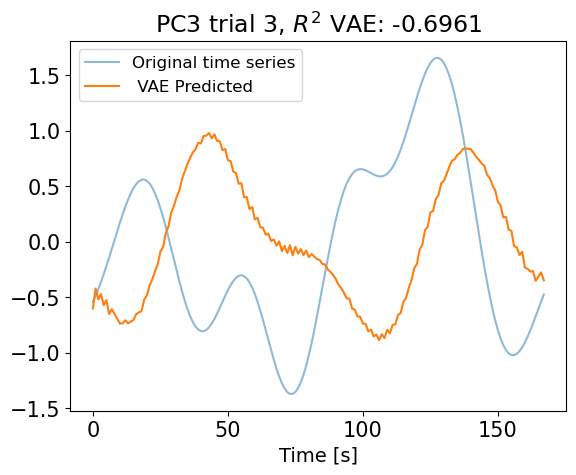

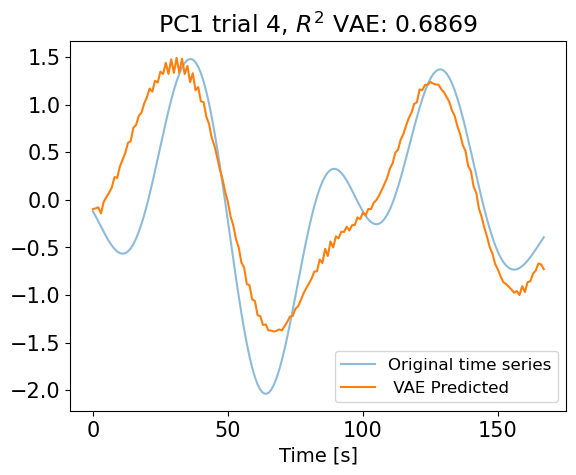

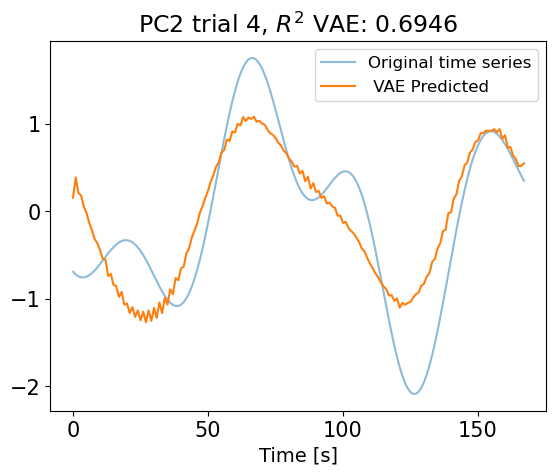

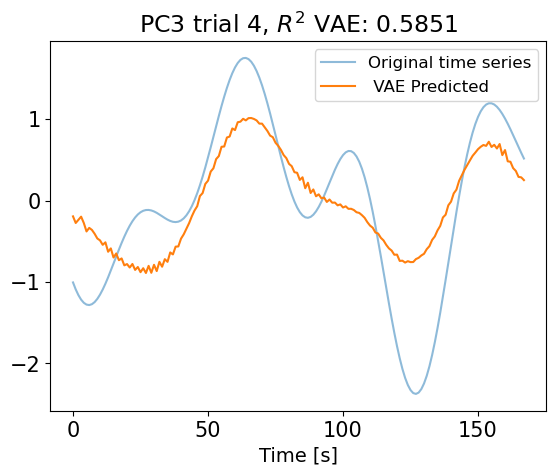

#################################################################
Original pupil shape: (3, 168)
Rev Legendre pupil shape: (3, 168)
Original PC data shape: (3, 3, 168)
Rev Embeddings PC time series shape: (3, 3, 168)
Rev Legendre PC time series shape: (3, 3, 168)
Predicted PC time series shape: (3, 3, 168)
Linear Predicted PC time series shape: (3, 3, 168)
#################################################################


In [17]:
# Cheking inverse Legendre transformation of original data
# Analisi per set:


targets_time_series = reconstruct_signal_from_embedding(rev_target_data[0,0,:,:].T ,embedding_dim=embedding_dim, delay=tau) #Dummy method
n_time_step = np.array(targets_time_series.shape[0])
print('n_time_step:', n_time_step)

targets_time_series = np.zeros((range_set, n_components, n_time_step))
predicted_time_series = np.zeros((range_set, n_components, n_time_step))
linear_predicted_time_series = np.zeros((range_set, n_components, n_time_step))
original_time_series = np.zeros((range_set, n_components, n_time_step))
input_original_time_series = np.zeros((range_set, n_time_step))


for i in range(range_set):
    for j in range(n_components):
        targets_time_series[i,j,:] = reconstruct_signal_from_embedding(rev_target_data[i,j,:,:].T,embedding_dim=embedding_dim, delay=tau)
        predicted_time_series[i,j,:] = reconstruct_signal_from_embedding(rev_predicted_data[i,j,:,:].T,embedding_dim=embedding_dim, delay=tau)
        #linear_predicted_time_series[i,j,:] = reconstruct_signal_from_embedding(rev_linear_predicted_data[i,j,:,:].T,embedding_dim=embedding_dim, delay=tau)
        original_time_series[i,j,:] = reconstruct_signal_from_embedding(embedded_matrix[i,j,:,:].T,embedding_dim=embedding_dim, delay=tau)
    input_original_time_series[i,:] = reconstruct_signal_from_embedding(rev_input_data[i,:].T,embedding_dim=embedding_dim, delay=tau)



'''
for i in range(range_set):
    #r2_pupil = r2_score(pupil_signal[i,:], input_original_time_series[i,:])
    plt.plot(input_original_time_series[i,:], label='Rev Pupil')
    plt.plot(pupil_signal[i,:], label='Original Pupil', alpha = 0.5)
    plt.title(f'Pupil dimensionality recovery {i+1}')
    plt.legend()
    plt.show()
'''

for i in range(range_set):
    for j in range(n_components):

        r2_vae = r2_score(original_time_series[i,j,:],predicted_time_series[i,j,:])
        r2_linear = r2_score(original_time_series[i,j,:],linear_predicted_time_series[i,j,:])

        #plt.plot(targets_time_series[i,j,:], label='Target dim reduced')
        plt.plot(original_time_series[i,j,:], label='Original time series', alpha = 0.5)
        #plt.plot(PC_signal[i,j,:], label='PC time series from original data', alpha = 0.5) # Check of indexes for time association recovery
        plt.plot(predicted_time_series[i,j,:], label=' VAE Predicted')
        #plt.plot(linear_predicted_time_series[i,j,:], label='Linear Predicted')
        plt.title(f'PC{j+1} trial {index[i]}, $R^2$ VAE: {r2_vae:.4f}',fontsize=17)
        plt.xlabel('Time [s]',fontsize=14)
        plt.legend(fontsize = 12)
        plt.tick_params(axis='both', which='major', labelsize=15)
        plt.show()

print('#################################################################')
print('Original pupil shape:', pupil_signal.shape)
print('Rev Legendre pupil shape:', input_original_time_series.shape)
print('Original PC data shape:', PC_signal.shape)
print('Rev Embeddings PC time series shape:', original_time_series.shape)
print('Rev Legendre PC time series shape:', targets_time_series.shape)
print('Predicted PC time series shape:', predicted_time_series.shape)
print('Linear Predicted PC time series shape:', linear_predicted_time_series.shape)
print('#################################################################')


            

### PCA inversion

In [18]:
spatial_shape = (56, 48, 32)

n_voxels = PCA_transformation[0].components_.shape[1]

fmri_functional_data = np.zeros((range_set,56 ,48, 32, n_time_step))
recon_functional_data = np.zeros((range_set,56 ,48, 32, n_time_step))

fmri_dynamics = np.zeros((range_set, active_voxels, n_time_step))
recon_dynamics = np.zeros((range_set, active_voxels, n_time_step))


print('Decoder dataset shape:', decoder_dataset_dummy.shape)
original_fmri_data = np.zeros((range_set,56 ,48, 32, n_time_step))

r2_fmri_vae = []

# Invert normalizazion of data:
for i in range(len(PC_dataset)):
    # Estrae la matrice normalizzata per il set i (forma: (n_components, T))
    pc_norm = original_time_series[i]
    pc_recon_norm = predicted_time_series[i]
    n_components, T = pc_norm.shape

    # Crea una matrice vuota per contenere i dati invertiti per questo set
    pc_inv = np.empty_like(pc_norm)
    pr_recon_inv = np.empty_like(pc_recon_norm)
    
    # Per ogni componente j, inverte la normalizzazione: x_original = normalized * std + mu
    for j in range(n_components):
        mu, std = norm_params[i][j]
        pc_inv[j] = pc_norm[j] * std + mu
        pr_recon_inv[j] = pc_recon_norm[j] * std + mu  
    
    original_time_series[i] = pc_inv
    predicted_time_series[i] = pr_recon_inv

for i in range(range_set):

    pca_model_i = PCA_transformation[i]
    # Reshape the 1D time-series to 2D with shape (n_time_step, 1) so that inverse_transform works correctly.
    fmri_dynamics[i] = pca_model_i.inverse_transform(original_time_series[i].reshape(-1, n_components)).T
    recon_dynamics[i] = pca_model_i.inverse_transform(predicted_time_series[i].reshape(-1, n_components)).T

    r2_inv_trasf = r2_score(fmri_dynamics[i].flatten(), recon_dynamics[i].flatten())
    r2_fmri_vae.append(r2_inv_trasf)
    r2_original = r2_score(fmri_dynamics[i].flatten(), decoder_dataset_dummy[i].flatten())
    error = mean_squared_error(fmri_dynamics[i].flatten(), decoder_dataset_dummy[i].flatten())
    print(f'R2 score PC1/PC1 recon set {i+1}: ', r2_inv_trasf, 'r2 with original data:', r2_original)
    #print(f'R2 score ORIGINAL fmri / PCA inverted recon set {i+1}: ', r2_original)

    # Reconstruct the 4D functional data from the PCA dynamics
    recon_functional_data[i] = invert_functional_data(recon_dynamics[i], active_voxels_indices[i], spatial_shape, n_time_step) # PC1 recon
    fmri_functional_data[i] = invert_functional_data(fmri_dynamics[i], active_voxels_indices[i], spatial_shape, n_time_step) # PC1 original
    original_fmri_data[i] = invert_functional_data(decoder_dataset_dummy[i], active_voxels_indices[i], spatial_shape, n_time_step) # No PCA applied

r2_fmri_vae = np.array(r2_fmri_vae)


print('Active voxels shape:' , active_voxels_indices.shape)
print('Fmri functional data shape:', fmri_functional_data.shape)
print('Recon functional data shape:', recon_functional_data.shape)
print('Fmri flatten data shape:', fmri_dynamics.shape)
print('Recon flatten data shape:', recon_dynamics.shape)

Decoder dataset shape: (3, 21680, 168)
R2 score PC1/PC1 recon set 1:  0.6451692059181786 r2 with original data: -2.560740610087815
R2 score PC1/PC1 recon set 2:  0.812896512207658 r2 with original data: -3.7881325821079095
R2 score PC1/PC1 recon set 3:  0.6841585700016731 r2 with original data: -5.103740077181645
Active voxels shape: (3, 21680)
Fmri functional data shape: (3, 56, 48, 32, 168)
Recon functional data shape: (3, 56, 48, 32, 168)
Fmri flatten data shape: (3, 21680, 168)
Recon flatten data shape: (3, 21680, 168)


Trial 2 - R2 VAE: 0.9998, R2 with Original: -1.6630
Trial 3 - R2 VAE: -0.9826, R2 with Original: -2.1128
Trial 4 - R2 VAE: -3.0000, R2 with Original: -0.4079


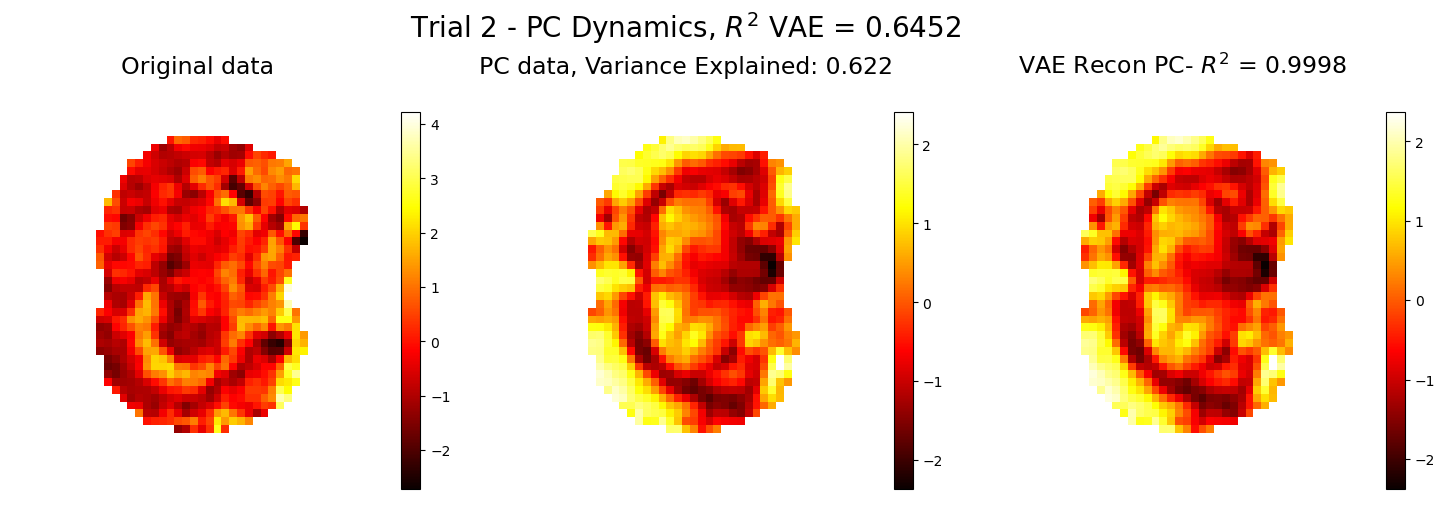

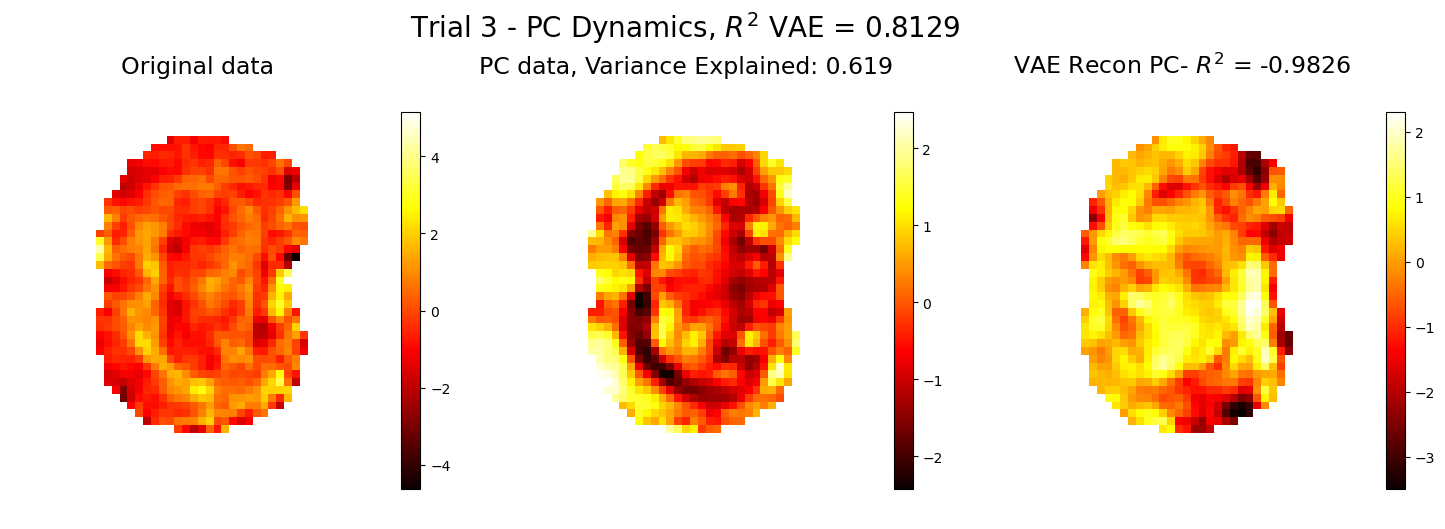

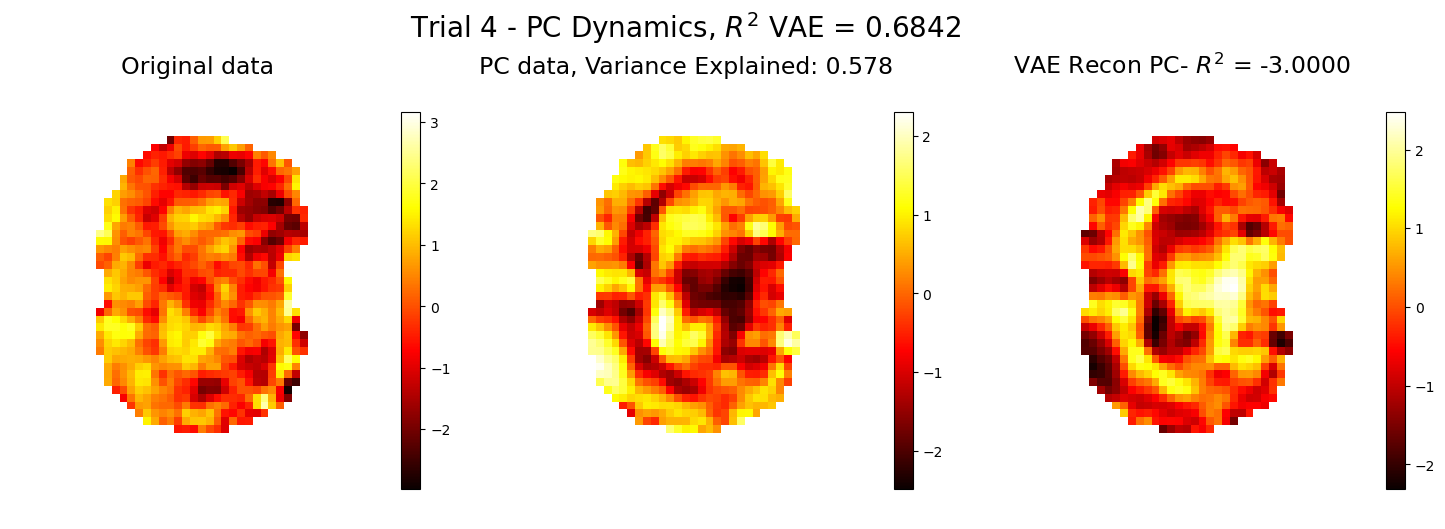

In [19]:
#Note: sometimes the data are inverted due to PCA inversion, which denormalizes data

slice = 16
for i in range(range_set):

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    data1 = np.mean(fmri_functional_data[i, :, :, slice, :], axis=-1)
    data2 = np.mean(recon_functional_data[i, :, :, slice, :], axis=-1)
    data3 = np.mean(original_fmri_data[i, :, :, slice, :], axis=-1)
    fig.suptitle(f'Trial {index[i]} - PC Dynamics, $R^2$ VAE = {r2_fmri_vae[i]:.4f}', fontsize= 20)


    mask3 = ~np.isnan(data3)
    global_mean3 = np.nanmean(data3)
    global_std3 = np.nanstd(data3)
    data3[mask3] = (data3[mask3] - global_mean3) / global_std3

    im0 = axs[0].imshow(data3, cmap='hot')
    axs[0].set_title('Original data', fontsize = 17)
    axs[0].axis('off')
    fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    
    mask1 = ~np.isnan(data1)
    global_mean1 = np.nanmean(data1)
    global_std1 = np.nanstd(data1)
    data1[mask1] = (data1[mask1] - global_mean1) / global_std1

    mask2 = ~np.isnan(data2)
    global_mean2 = np.nanmean(data2)
    global_std2 = np.nanstd(data2)
    data2[mask2] =  (data2[mask2] - global_mean2) / global_std2

    r2_recon = r2_score(data1[mask1].flatten(), data2[mask2].flatten())
    r2_original_slice = r2_score(data1[mask1].flatten(), data3[mask3].flatten())


    im1 = axs[1].imshow(data1, cmap='hot') #,vmin = vmin, vmax = vmax)
    axs[1].set_title(f'PC data, Variance Explained: {var_explained[i,n_components-1]:.3f} ',fontsize = 17)
    axs[1].axis('off')
    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    im2 = axs[2].imshow(data2, cmap='hot') #,vmin = vmin, vmax = vmax)
    axs[2].set_title(f'VAE Recon PC- $R^2$ = {r2_recon:.4f}',fontsize = 17)
    axs[2].axis('off')
    fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    print(f'Trial {index[i]} - R2 VAE: {r2_recon:.4f}, R2 with Original: {r2_original_slice:.4f}')


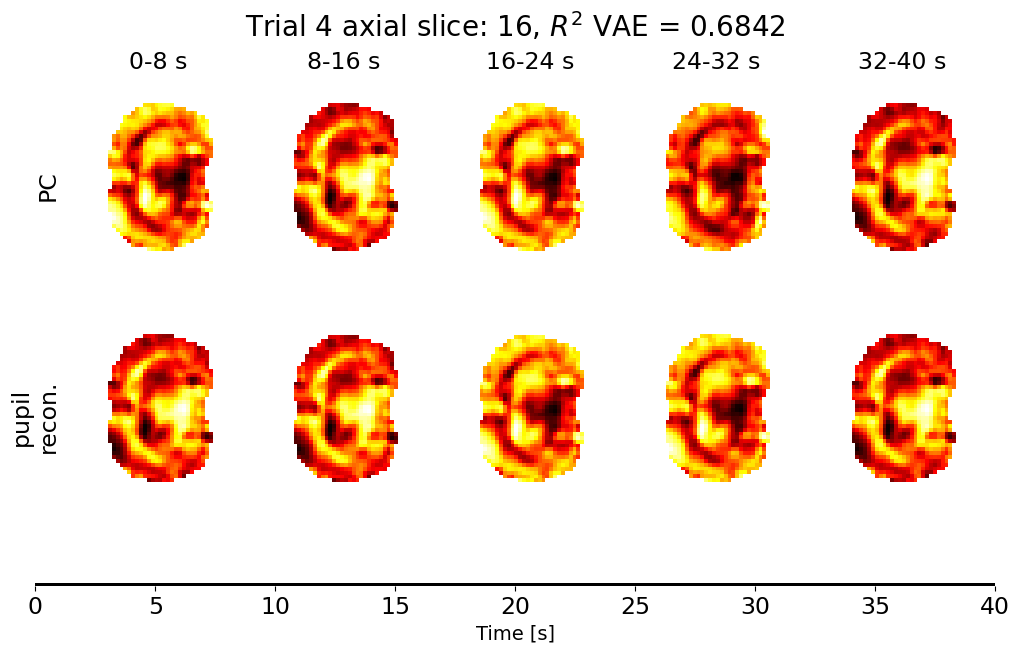

In [20]:
set_index = 2
slice_index = 16
N = 5  # numero di segmenti
nx, ny = 56, 48

data_true = fmri_functional_data[set_index, :, :, slice_index, :]
data_pupil = recon_functional_data[set_index, :, :, slice_index, :]

time_start = 0
time_window = 40
time_stop = time_window + time_start
dt = int(time_window / N)

fig, axs = plt.subplots(2, N, figsize=(12, 6))
plt.subplots_adjust(wspace=0, hspace=0)
fig.patch.set_facecolor('white')

# Titolo generale in nero
fig.suptitle(
    f"Trial {index[set_index]} axial slice: {slice_index}, $R^2$ VAE = {r2_fmri_vae[set_index]:.4f}",
    color='black', fontsize=20
)

for i in range(N):
    frame_true = np.mean(data_true[:, :, time_start : time_start + dt], axis=-1)
    frame_pupil = np.mean(data_pupil[:, :, time_start : time_start + dt], axis=-1)
    
    # (eventuale R2 frame, se serve)
    r2_frame = r2_score(
        fmri_dynamics[set_index, :, time_start : time_start + dt].flatten(),
        recon_dynamics[set_index, :, time_start : time_start + dt].flatten()
    )
    
    # Immagini
    axs[0, i].imshow(frame_true, cmap='hot')
    axs[1, i].imshow(frame_pupil, cmap='hot')

    if i == 0:
        # Prima colonna: etichette di colonna e righe, ma NESSUNA numerazione sugli assi
        axs[0, i].set_ylabel("PC", fontsize=17, color='black')
        axs[1, i].set_ylabel("pupil\nrecon.", fontsize=17, color='black')
        axs[0, i].set_title(f"{time_start}-{time_start + dt} s", color='black', fontsize = 17)

        # Rimuoviamo i tick numerici ma lasciamo le label di riga
        axs[0, i].tick_params(axis='both', which='both',
                             bottom=False, left=False, 
                             labelbottom=False, labelleft=False,
                             colors='black')
        axs[1, i].tick_params(axis='both', which='both',
                             bottom=False, left=False, 
                             labelbottom=False, labelleft=False,
                             colors='black')
        
        # Rimuoviamo le spines
        for spine in axs[0, i].spines.values():
            spine.set_visible(False)
        for spine in axs[1, i].spines.values():
            spine.set_visible(False)
    else:
        # Colonne successive: tutto off
        axs[0, i].axis('off')
        axs[1, i].axis('off')
        axs[0, i].set_title(f"{time_start}-{time_start + dt} s", color='black', fontsize = 17)

    time_start += dt

# Timeline in basso
ax_timeline = fig.add_axes([0.1, 0.02, 0.8, 0.005], facecolor='white')
ax_timeline.plot([0, time_stop], [0, 0], 'k-', lw=3)
ax_timeline.set_xlim(0, time_stop)
ax_timeline.set_ylim(-0.5, 0.5)
ax_timeline.set_xlabel("Time [s]", fontsize=14, color='black')

for spine in ax_timeline.spines.values():
    spine.set_visible(False)
ax_timeline.tick_params(axis='x', colors='black', labelsize=17)
ax_timeline.tick_params(axis='y', left=False, labelleft=False)

plt.show()